# 2.线性回归的从0开始实现

In [1]:
# 控制画图不弹窗，行内显示
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 1.生成数据集
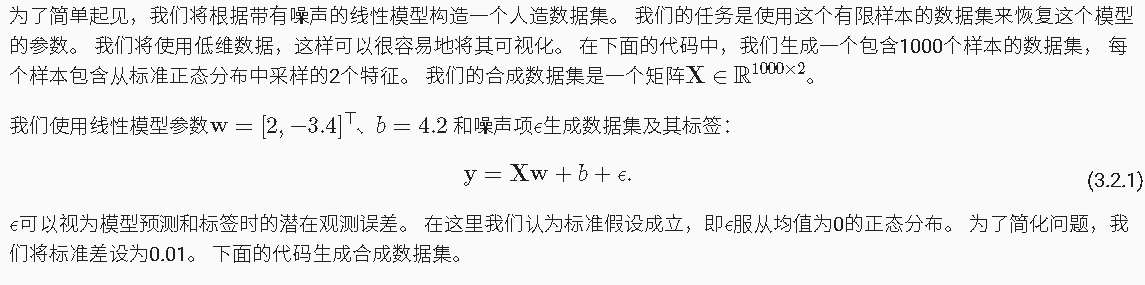

In [7]:
def synthetic_data(w,b,num_examples):#@save
    """生成y=wx+b噪声"""
    X=torch.normal(0,1,(num_examples,len(w)))
    y=torch.matmul(X,w)+b
    y+=torch.normal(0,0.001,y.shape)
    return X,y.reshape((-1,1))
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)
# 注意，features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）。
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.9875, -0.7056]) 
label: tensor([8.5736])


通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。

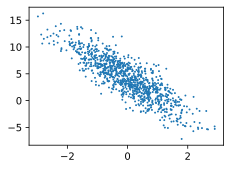

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)

## 2.读取数据集
回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

In [9]:
def data_tier(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
#     随机读取样本
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。

In [12]:
batch_size=10
for X,y in data_tier(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 1.0139,  1.7904],
        [-0.3401, -1.0139],
        [-0.4404,  0.3096],
        [ 1.1729, -0.6844],
        [ 0.0712,  0.1221],
        [ 1.2981, -1.6109],
        [ 2.3941, -1.0565],
        [ 0.3464,  1.7062],
        [-0.3233,  0.6305],
        [-2.3138, -0.9517]]) 
 tensor([[ 0.1396],
        [ 6.9668],
        [ 2.2678],
        [ 8.8720],
        [ 3.9253],
        [12.2743],
        [12.5803],
        [-0.9101],
        [ 1.4112],
        [ 2.8087]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。 上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

### 3.初始化模型参数
在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [26]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)
print(w,'\n',b)

tensor([[-0.0060],
        [-0.0116]], requires_grad=True) 
 tensor([0.], requires_grad=True)


在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 每次更新都需要计算损失函数关于模型参数的梯度。 有了这个梯度，我们就可以向减小损失的方向更新每个参数。 因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。 我们使用 2.5节中引入的自动微分来计算梯度。

### 4.定义模型
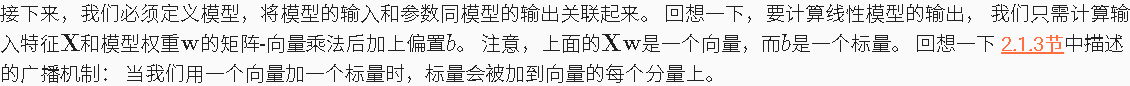

In [16]:
def linreg(X,w,b):#@save
    return torch.matmul(X,w)+b

### 5.定义损失函数
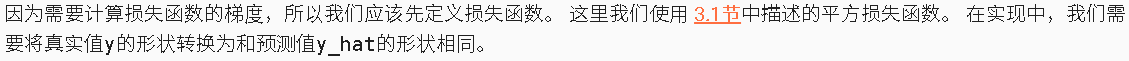

In [17]:
def squared_loss(y_hat,y):
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

### 6.定义优化算法
正如我们在 3.1节中讨论的，线性回归有解析解。 尽管线性回归有解析解，但本书中的其他模型却没有。 这里我们介绍小批量随机梯度下降。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。 接下来，朝着减少损失的方向更新我们的参数。 下面的函数实现小批量随机梯度下降更新。 该函数接受模型参数集合、学习速率和批量大小作为输入。每 一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [21]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 7.训练
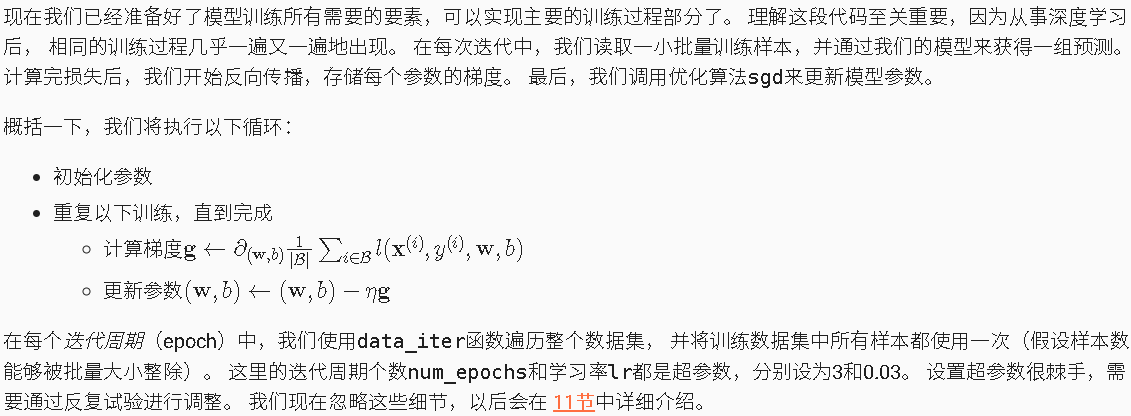

In [22]:
lr=0.03
num_epochs=3
net=linreg
loss=squared_loss
for epoch in range(num_epochs):
    for X,y in data_tier(batch_size,features,labels):
        l=loss(net(X,w,b),y)# X和y的小批量损失
         # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'expoch{epoch+1},loss{float(train_l.mean()):f}')
        

expoch1,loss0.038029
expoch2,loss0.000101
expoch3,loss0.000001


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。 事实上，真实参数和通过训练学到的参数确实非常接近。

In [23]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0004, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。 在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。 幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。 其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测

### 9.练习


在线性回归中，由于只有一层神经网络，且SGD过程中，梯度求导后结果与参数本身无关，而是取决于输入 
 和 
 ，因此，可以将权重初始化为0，算法仍然有效（试验如下）。
但是，在多层神经网络中，如果将权重初始化为0，或者其他统一的常量，会导致后面迭代的权重更新相同，并且神经网络中的激活单元的值相同，输出的梯度也相等，导致对称性问题，无法进行独立学习，找到最优解。

In [30]:
#1.
w = torch.zeros((2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(w,'\n',b)
lr=0.03
num_epochs=3
net=linreg
loss=squared_loss
for epoch in range(num_epochs):
    for X,y in data_tier(batch_size,features,labels):
        l=loss(net(X,w,b),y)# X和y的小批量损失
         # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'expoch{epoch+1},loss{float(train_l.mean()):f}')
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

tensor([[0.],
        [0.]], requires_grad=True) 
 tensor([0.], requires_grad=True)
expoch1,loss0.041579
expoch2,loss0.000110
expoch3,loss0.000001
w的估计误差: tensor([ 0.0005, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)




---

#### 2.假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?

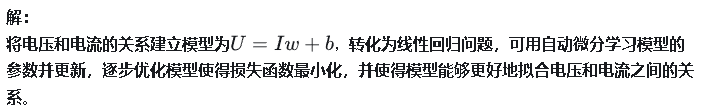

---

#### 3.能基于普朗克定律使用光谱能量密度来确定物体的温度吗？
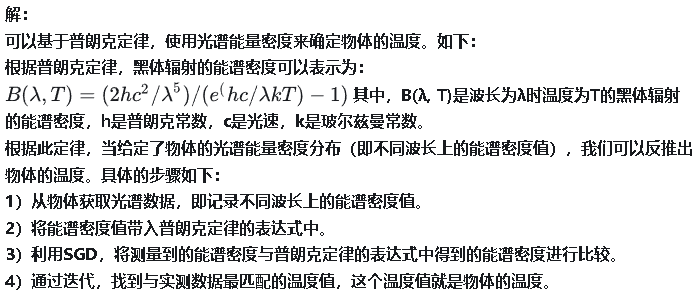

### 4. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？

解：
二阶导数包含了更多关于损失函数曲率的信息，因此在某些情况下，计算二阶导数可能有助于更快地收敛和更准确的更新。然而，由于计算复杂度较高，通常在实际应用中很少使用。
以下是计算二阶导数时可能会遇到的问题，以及可能的解决方法：
1）计算复杂度高： 计算Hessian矩阵需要更多的计算资源和时间，尤其在大规模数据和复杂模型上。
解决方法： 通常可以使用近似方法来估计二阶导数，例如L-BFGS（Limited-memory Broyden-Fletcher-Goldfarb-Shanno）等优化算法。这些方法在一定程度上降低了计算成本，同时仍能提供较好的优化效果。
2）存储需求大： Hessian矩阵的存储需求随着参数数量的增加而增加，可能导致内存不足的问题。
解决方法： 使用一些高效的矩阵近似方法，如块对角近似（block-diagonal approximation）或采样Hessian近似，来减少存储需求。
3）数值不稳定性： 在计算Hessian矩阵时，可能会遇到数值不稳定性，导致数值误差累积，影响优化结果。
解决方法： 使用数值稳定的计算方法，例如通过添加小的正则化项来避免矩阵的奇异性。另外，选择合适的优化算法和学习率调度也可以帮助稳定优化过程。
4）局部极小值和鞍点： 在高维空间中，存在许多局部极小值和鞍点，这可能导致Hessian矩阵的谱值较小，使得计算二阶导数的结果不稳定。
解决方法： 使用正则化技术、随机性优化方法（如随机梯度牛顿法）或基于自适应学习率的算法，可以帮助逃离局部极小值和鞍点。
总之，虽然计算二阶导数在优化中具有一定的潜在优势，但在实际应用中，由于上述问题和计算成本，往往更常使用一阶优化方法（如SGD、Adam等）及其变种。选择优化方法时，需要根据具体问题的特点来权衡二阶信息带来的优势和计算成本。

---

### 5. 为什么在squared_loss函数中需要使用reshape函数？

解：
因为y_hat和y的元素个数相同，但shape不一定相同（虽然在本节中二者shape一致），为了保证计算时不出错，故使用reshape函数将二者的shape统一。

---


### 6.尝试使用不同的学习率，观察损失函数值下降的快慢。
学习率越小，损失函数值下降越慢，反之亦然；
但当学习率过高时，损失函数值将出现inf和nan。试验如下：

In [38]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(w,'\n',b)
lr=0.01
num_epochs=10
net=linreg
loss=squared_loss
for epoch in range(num_epochs):
    for X,y in data_tier(batch_size,features,labels):
        l=loss(net(X,w,b),y)# X和y的小批量损失
         # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'expoch{epoch+1},loss{float(train_l.mean()):f}')
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

tensor([[0.0085],
        [0.0052]], requires_grad=True) 
 tensor([0.], requires_grad=True)
expoch1,loss2.264305
expoch2,loss0.317075
expoch3,loss0.044612
expoch4,loss0.006304
expoch5,loss0.000894
expoch6,loss0.000128
expoch7,loss0.000019
expoch8,loss0.000003
expoch9,loss0.000001
expoch10,loss0.000001
w的估计误差: tensor([ 0.0003, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)


---

### 7.如果样本个数不能被批量大小整除，data_iter函数的行为会有什么变化？
解：
当num_examples不能被batch_size整除，data_iter函数的行为会有以下变化：

1）最后一个批次的样本数量会小于batch_size：在for循环中，当i递增到最后一个不完整的批次时，min(i+batch_size, num_examples)会返回一个小于batch_size的值，这意味着最后一个批次的样本数量会少于batch_size。
2）最后一个批次中的样本顺序将不一定是随机的：由于样本在indices列表中是随机排列的，而最后一个批次的样本数量小于batch_size，因此在取最后一个批次时，实际上是从indices列表末尾开始继续取样本，直到达到indices列表的末尾。因此，最后一个批次中的样本顺序将不再随机，而是按照indices列表的顺序。
随机化样本的目的通常是为了打乱样本的顺序，使得模型在训练过程中能够接触到各种不同类型的样本。但由于最后一个不完整批次的样本顺序不再随机，可能会引入一些偏差。因此，在设计实际应用中的data_iter函数时，可以考虑在最后一个不完整批次中重新进行随机化操作，以减小这种偏差的影响。
试验如下：

In [39]:
def data_iter(batch_size, features, labels):
    num_examples = int(len(features)/100)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
batch_size = 7

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)

tensor([[ 0.9875, -0.7056],
        [ 0.1050, -0.0717],
        [ 1.2513,  0.1250],
        [-0.0766,  0.0407],
        [-2.3786,  1.3409],
        [ 0.0081, -0.2264],
        [-1.8465,  1.2212]]) 
 tensor([[ 8.5736],
        [ 4.6527],
        [ 6.2769],
        [ 3.9097],
        [-5.1139],
        [ 4.9849],
        [-3.6458]])
tensor([[-0.0949, -0.4765],
        [ 1.3744,  2.6156],
        [ 0.5733,  0.3924]]) 
 tensor([[ 5.6317],
        [-1.9443],
        [ 4.0121]])
